In [1]:
import numpy as np
from scipy import integrate
from scipy.constants import pi, physical_constants
from scipy.stats import norm
from scipy.special import gamma
from matplotlib import pyplot as plt
# --- Costanti fisiche e rivelatore  -----------------------
G_F_MeV = physical_constants["Fermi coupling constant"][0] * 1e-6  # MeV^-2 
m_e     = physical_constants["electron mass energy equivalent in MeV"][0]
conversion = 0.3894e-21  # cm² / MeV^-2

mass_kton      = 2.14
m_H2O          = 2.9915e-23  # g
mass_g         = mass_kton * 1e9
n_e_per_mol    = 10
Ne             = (mass_g/m_H2O)*n_e_per_mol

# Flusso (SN pinched + oscillazioni)
sin2th_W = 0.231
g_L      = 0.5 + sin2th_W
g_L_mu   = -0.5 + sin2th_W
g_R      = sin2th_W
#P_ee     = 2.2e-2  #normal ordering
P_ee     = 0.296    #inverted ordering

L_max   = 4e53        # erg/s
E_avg   = 13          # MeV
D_cm    = 51.4e3*3.086e18
erg_to_MeV = 624150.64799632
#Phi_max = (L_max*erg_to_MeV/E_avg) / (4*pi*D_cm**2)
Phi_max = 6.1e10

xi      = 5
T_spec  = E_avg/(1+xi)

def phi_spectrum(E, T=T_spec, xi=xi):
    return ( E**xi * np.exp(-E/T) )/( T**(1+xi)*gamma(1+xi) )

def phi_e(Enu):
    return (P_ee)*phi_spectrum(Enu)

def phi_x(Enu):
    return  (1-P_ee)*phi_spectrum(Enu) #considero mu e tau

# --- sezione differenziale ν–e  -----------------------------
def sigma_diff(Enu, Ee):
    Te = Ee - m_e
    if (Enu <= Te) or (Enu <= 0): 
        return 0.0
    t1 = g_L**2
    t2 = g_R**2 * (1 - Te/Enu)**2
    t3 = g_L*g_R * m_e*Te/Enu**2
    return (2*G_F_MeV**2*m_e/np.pi)*(t1 + t2 - t3)*conversion

def sigma_diff_mu(Enu, Ee):
    Te =  Ee - m_e
    if(Enu <= Te) or (Enu <= 0):
        return 0.0
    t1 = g_L_mu**2
    t2 = g_R**2*(1-Te/Enu)**2
    t3 = g_L_mu * g_R * m_e*Te/Enu**2
    return(2*G_F_MeV**2*m_e/np.pi)*(t1+t2-t3)*conversion

def sigma_diff_tot(Enu, Ee):
    return sigma_diff(Enu, Ee) #+ 2*sigma_diff_mu(Enu, Ee)



# --- cinematica inversa e Jacobiano ------------------------
def c_min(Te):
    return np.sqrt(Te/(Te + 2*m_e))

def E_nu(Te, costh):
    cmin = c_min(Te)
    denom = costh - cmin
    if denom <= 0: 
        return np.nan
    return m_e*cmin/denom

def jacobian(Te, costh):
    cmin = c_min(Te)
    # equivalente a m_e*cmin/(costh-cmin)**2
    #return Enu**2/m_e*np.sqrt((Te+2*m_e)/Te)
    return m_e*cmin/(costh-cmin)**2

# --- risposta energetica e angolare ------------------------
dEi   = 2.9    # sigma energia [MeV]

# Heaviside theta definition
Heaviside = lambda x : np.heaviside(x,0.5)
def eff_k2(Ee,c=0):
    """Returns the efficiency η of the Kamiokande detector as a function of the positron energy Ee [MeV]"""
    return 0.93 * ( 1 - 0.2/Ee - (2.5/Ee)**2 ) * Heaviside(Ee-2.6)

def resol_function(Ee,statistical,systematic):
    return statistical * np.sqrt(Ee/10.0) + systematic * (Ee/10.0)

def resolution_k2(Ee):
    return resol_function(Ee,1.27,1.0)


norm_gauss = lambda mu, x, sigma : 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-(x-mu)**2 / ( 2 * sigma**2))

# Response kernel for the measured energy in K2
def res_kernel_k2(Ee, Ei):
    return norm_gauss(Ee,Ei,resolution_k2(Ee))


# parametri smearing angolare
th_deg  = 18.0
dth_deg = 18.0
th   = np.deg2rad(th_deg)
dth  = np.deg2rad(dth_deg)
dn   = 0.424*dth*(1 - (dth**2)/24)
N2   = 1 - (1 + 2/dn)*np.exp(-2/dn)

def drho(c, dn):
    """dρ/dc(c) non normalizzato (funzione di un singolo c)."""
    return np.exp(-np.sqrt(2*(1 - c))/dn) / (dn**2 * N2)

def ang_resp_avg(c_meas, c_true):
    """
    Media su φ di dρ/dc, cioè P(c_meas | c_true).
    """
    integrand = lambda phi: drho(
        c_true * c_meas
        + np.sqrt(1 - c_true**2) * np.sqrt(1 - c_meas**2) * np.cos(phi),
        dn
    )
    return integrate.quad(integrand, 0, np.pi)[0] / (np.pi)

# --- funzione differenziale non smearata -------------------
def d2N_dE_dct_true(Ee, costh):
    Te = Ee - m_e
    if costh <= c_min(Te):
        return 0.0
    Enu = E_nu(Te, costh)
    if np.isnan(Enu):
        return 0.0
    return ( Ne * Phi_max *
        ( phi_e(Enu) + phi_x(Enu)/6 ) *
        sigma_diff_tot(Enu, Ee) *
        jacobian(Te, costh)
    )

# --- ora la doppia convoluzione ----------------------------
Ee_meas_vals  = np.linspace(4.5, 60, 10)
cos_meas_vals = np.linspace(0.90, 1.0,  10)




In [2]:
def d2N_dEmeas_dcosmeas(E_meas, cos_meas):
    integrand = lambda costh_true, Ee: (
        d2N_dE_dct_true(Ee, costh_true)
        * res_kernel_k2(Ee, E_meas)
        * eff_k2(Ee, c=0)
        * ang_resp_avg(cos_meas, costh_true)
    )

    # limiti cinematici:
    # - Ee da soglia (m_e + 0.1 MeV) a un valore massimo (es. 100 MeV)
    # - costh_true da c_min(Te) a 1
    return integrate.dblquad(
        integrand,
        2.1,       # limite inferiore di Ee
        100,             # limite superiore di Ee
        lambda Ee: c_min(Ee - m_e),  # soglia inferiore in cosθ
        lambda Ee: 1.0               # soglia superiore in cosθ
    )[0]


In [ ]:
# --- Parametri del primo evento Kamiokande ---
E_event_meas   = 20   # MeV  (inserisci qui l’energia ricostruita)
cos_event_meas = np.cos(np.deg2rad(18))  # (inserisci qui il coseno dell’angolo misurato)

# --- Valutazione del rate per quell’evento singolo ---
rate_event = d2N_dEmeas_dcosmeas(E_event_meas, cos_event_meas)

print(f"Rate previsto per il primo evento Kamiokande (@ E_meas={E_event_meas} MeV, "
      f"cosθ_meas={cos_event_meas}): {rate_event:.3e} ")

C:\Users\Asus\AppData\Local\Temp\ipykernel_17268\3463380493.py:8: RuntimeWarning: overflow encountered in exp
  exponential = np.exp(exp_argument)


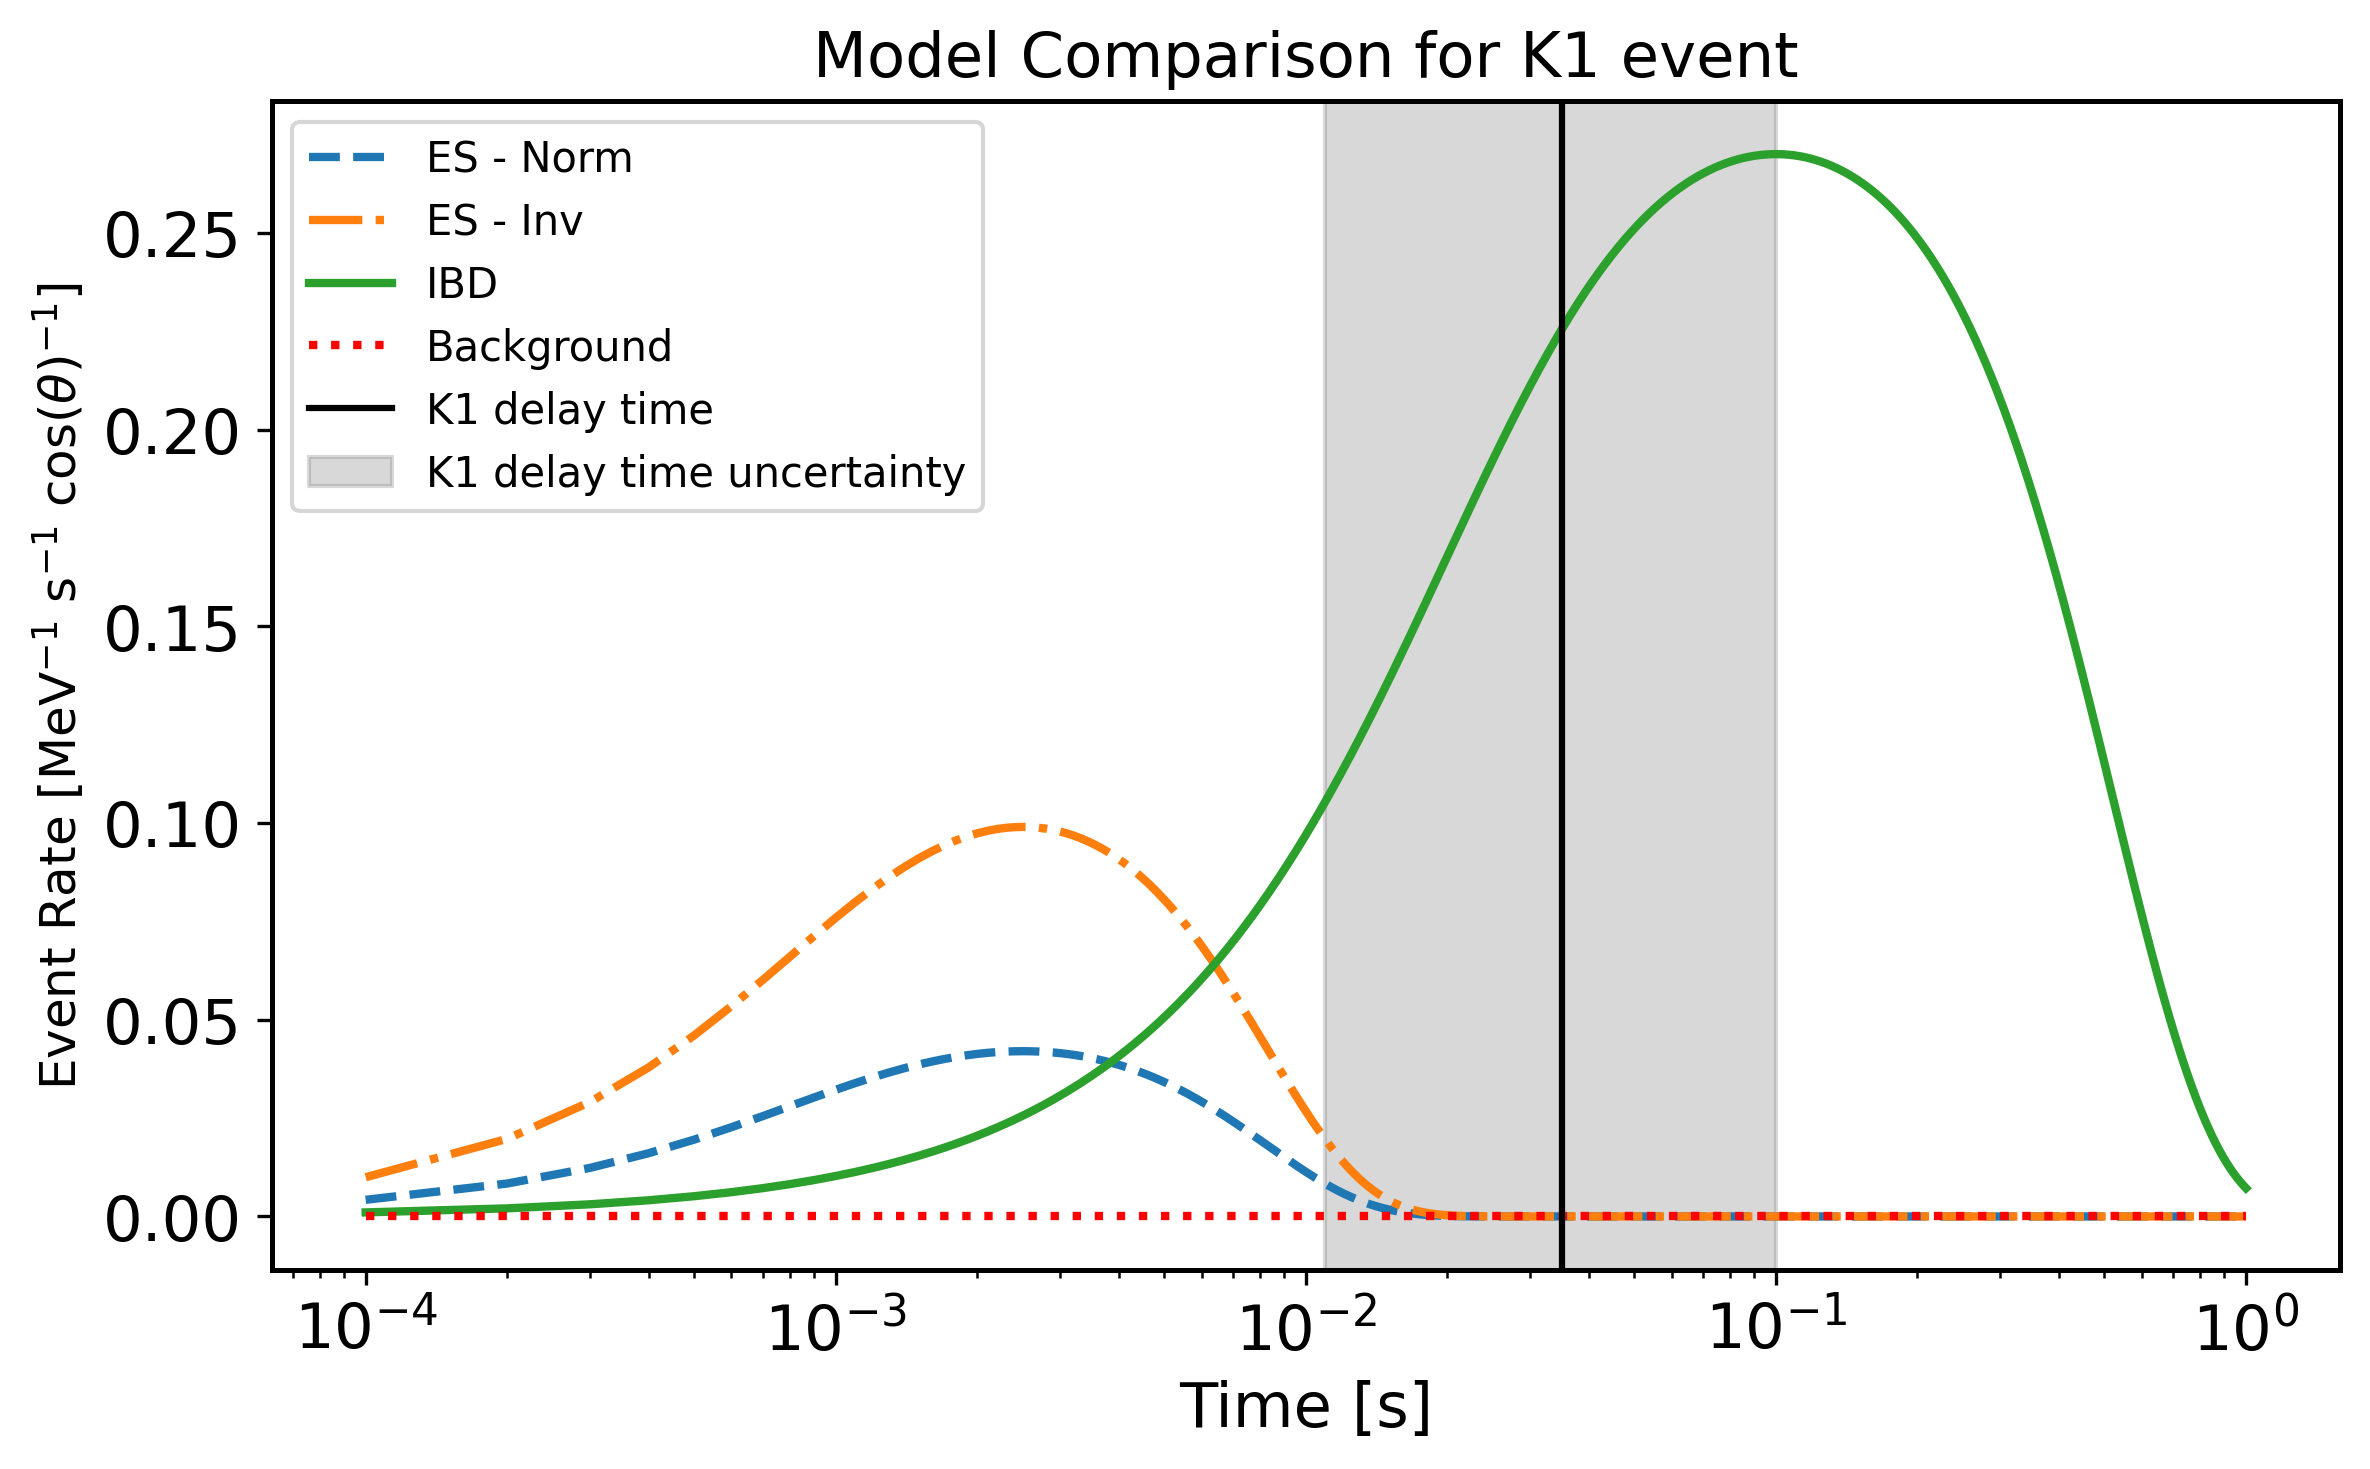

In [4]:
rate_event_ibd = 0.27 #old analysis
rate_event_es_norm = 0.042 #normal ordering
rate_event_es_inv = 0.099 #inverted ordering

# --- Funzioni dei modelli ---
def f_cal(y, x, alpha, n):
    exp_argument = n * (y**alpha - x**alpha)
    exponential = np.exp(exp_argument)
    constant = alpha * x**(alpha + n) / ((y + 1e-20)**n)
    return np.heaviside(y, 0) * ((1 + alpha * x**alpha) / (exponential + constant))**(1 / n)

def f_cal_a(t, t0, tau_a):
    return f_cal(t / tau_a, t0 / tau_a, alpha=2, n=2)

# --- Parametri ---
t = np.arange(0.0001, 1, 0.0001)


# Background
bkg_rate = 1.0e-5  # Hz/MeV
delta_E = 5.8  # MeV
bkg_rate_total = bkg_rate * delta_E  # eventi/s

# Parametri evento K1
k1_time = 0.035  # secondi
k1_error = 0.005  # secondi

# --- Stile elegante ---

fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

# Rendi i bordi del riquadro neri e più spessi
for spine in ax.spines.values():
    spine.set_edgecolor('black')   # colore del bordo
    spine.set_linewidth(1.2)       # spessore opzionale


# --- Plotti ---
ax.plot(t, rate_event_es_norm* f_cal_a(t, 0.0025, 0.0082), linestyle='--', linewidth=2, label='ES - Norm')

ax.plot(t, rate_event_es_inv* f_cal_a(t, 0.0025, 0.0082), linestyle='-.', linewidth=2, label='ES - Inv')
ax.plot(t, rate_event_ibd * f_cal_a(t, 0.1, 0.52), linestyle='-', linewidth=2, label='IBD')
ax.hlines(bkg_rate_total, xmin=t[0], xmax=t[-1], colors='red', linestyles=':', linewidth=2, label='Background')

# Linea verticale per K1
ax.axvline(k1_time, color='black', linestyle='-', linewidth=1.5, label='K1 delay time')

# Banda di errore (tipo pannello)
ax.axvspan(k1_time - 0.024, k1_time + 0.065, color='gray', alpha=0.3, label='K1 delay time uncertainty')

# --- Dettagli grafico ---
ax.set_xscale('log')
ax.set_xlabel('Time [s]', fontsize=15)
ax.set_ylabel(r'Event Rate [MeV$^{-1}$ s$^{-1}$ cos($\theta$)$^{-1}$]', fontsize=12)

ax.set_title('Model Comparison for K1 event', fontsize=15)
ax.legend()
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
